# Photo-z Determination for SpIES High-z Candidates

Notebook that actually applies the algorithms from `SpIESHighzQuasarPhotoz.ipynb` to the quasar candidates.

In [1]:
## Read in the Training Data and Instantiating the Photo-z Algorithm

%matplotlib inline
from astropy.table import Table
import numpy as np
import matplotlib.pyplot as plt
data = Table.read('GTR-ADM-QSO-ir-testhighz_findbw_lup_2016_starclean.fits')

# Remove stars
qmask = (data['zspec']>0)
qdata = data[qmask]
print len(qdata)

# X is in the format need for all of the sklearn tools, it just has the colors
Xtrain = np.vstack([ qdata['ug'], qdata['gr'], qdata['ri'], qdata['iz'], qdata['zs1'], qdata['s1s2']]).T
#y = np.array(data['labels'])
ytrain = np.array(qdata['zspec'])

/Users/gtr/anaconda/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


234416


Since we are running on separate test data, we don't need to do a `train_test_split` here.  But we will scale the data.  Need to remember to scale the test data later!

In [2]:
# For algorithms that need scaled data:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(Xtrain)  # Don't cheat - fit only on training data

StandardScaler(copy=True, with_mean=True, with_std=True)

## Applying to Quasars Candidates

Quasars candidates from the legacy KDE algorithm are in<br>
`GTR-ADM-QSO-ir-testhighz_kdephotoz_lup_2016_quasar_candidates.dat`

Quasars candidates from the Random Forest Algorithm are in<br>
`GTR-ADM-QSO-ir_good_test_2016_out.fits`

Quasar candidates from the RF, SVM, and/or bagging algorithms are in<br>
`GTR-ADM-QSO-ir_good_test_2016_out_Stripe82all.fits`<br>

In the case of the latter file, this includes Stripe82 only.  If we run on the other files, we might want to limit to Stripe 82 to keep the computing time reasonable.

In [3]:
testdata = Table.read('GTR-ADM-QSO-ir_good_test_2016_out_Stripe82all.fits')

In [4]:
qsocandmask = ((testdata['ypredRFC']==0) | (testdata['ypredSVM']==0) | (testdata['ypredBAG']==0))
testdatacand = testdata[qsocandmask]
print len(testdata),len(testdatacand)

2029149 5486


In [5]:
Xtest = np.vstack([ testdatacand['ug'], testdatacand['gr'], testdatacand['ri'], testdatacand['iz'], testdatacand['zs1'], testdatacand['s1s2']]).T
XStest = scaler.transform(Xtest)  # apply same transformation to test data

Not currently executing the next 2 cells, but putting the code here in case we want to do it later.

In [ ]:
# Read in KDE candidates
dataKDE = Table.read('GTR-ADM-QSO-ir-testhighz_kdephotoz_lup_2016_quasar_candidates.dat', format='ascii')
print dataKDE.keys()
print len(XKDE)
XKDE = np.vstack([ dataKDE['ug'], dataKDE['gr'], dataKDE['ri'], dataKDE['iz'], dataKDE['zch1'], dataKDE['ch1ch2'] ]).T

In [ ]:
# Read in RF candidates
dataRF = Table.read('GTR-ADM-QSO-ir_good_test_2016_out.fits')
print dataRF.keys()
print len(dataRF)
# Canidates only
maskRF = (dataRF['ypred']==0)
dataRF = dataRF[maskRF]
print len(dataRF)

# X is in the format need for all of the sklearn tools, it just has the colors
XRF = np.vstack([ dataRF['ug'], dataRF['gr'], dataRF['ri'], dataRF['iz'], dataRF['zs1'], dataRF['s1s2']]).T

---

### Instantiate Photo-z Algorithm of Choice

Here using Nadaraya-Watson and Random Forests

In [6]:
import numpy as np
from astroML.linear_model import NadarayaWatson
model = NadarayaWatson('gaussian', 0.05)

In [7]:
model.fit(Xtrain,ytrain)

In [8]:
from sklearn.ensemble import RandomForestRegressor
modelRF = RandomForestRegressor()
modelRF.fit(Xtrain,ytrain)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_split=1e-07, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=10, n_jobs=1, oob_score=False, random_state=None,
           verbose=0, warm_start=False)

### Apply Photo-z Algorithm(s)

#### Random Forest

In [9]:
zphotRF = modelRF.predict(Xtest)

#### Nadaraya-Watson

In [10]:
zphotNW = model.predict(Xtest)

/Users/gtr/anaconda/lib/python2.7/site-packages/astroML/linear_model/kernel_regression.py:52: RuntimeWarning: invalid value encountered in divide
  return (K * self.y).sum(1) / K.sum(1)


Only need this if Xtest is too big

In [9]:
from dask import compute, delayed
def process(Xin):
    return model.predict(Xin)

# Create dask objects
dobjs = [delayed(process)(x.reshape(1,-1)) for x in Xtest]

In [ ]:
import dask.threaded
ypred = compute(*dobjs, get=dask.threaded.get)

In [ ]:
# The dask output needs to be reformatted.
zphotNW = np.array(ypred).reshape(1,-1)[0]

In [12]:
testdatacand['zphotNW'] = zphotNW
testdatacand['zphotRF'] = zphotRF

In [13]:
testdatacand.write('GTR-ADM-QSO-ir_good_test_2016_out_Stripe82all_zphot.fits', format='fits')

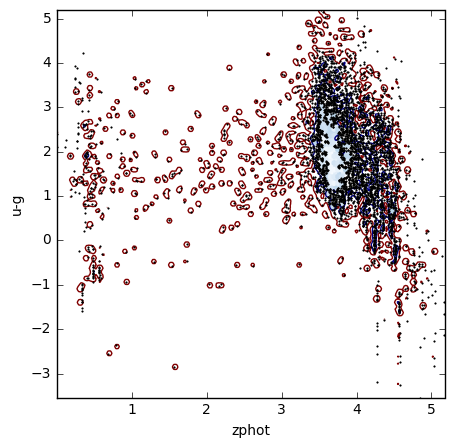

In [16]:
from densityplot import *
from pylab import *
fig = plt.figure(figsize=(5,5))
hex_scatter(testdatacand['zphotNW'],testdatacand['ug'], min_cnt=10, levels=2, std=True, smoothing=1,
            hkwargs={'gridsize': 100, 'cmap': plt.cm.Blues}, 
            skwargs={'color': 'k'})
plt.xlabel('zphot')
plt.ylabel('u-g')
#plt.xlim([-0.1,5.5])
#plt.ylim([-0.1,5.5])
plt.show()

(array([   2.,    1.,    0.,    3.,    1.,    1.,    1.,    5.,    8.,
           4.,    6.,    6.,    7.,    2.,    8.,   12.,   14.,   13.,
          29.,   29.,   19.,   30.,   43.,   40.,   37.,   28.,   40.,
          46.,   46.,   53.,   49.,   60.,   80.,   71.,   81.,   98.,
          97.,   97.,  130.,  165.,  166.,  181.,  228.,  316.,  390.,
         435.,  471.,  392.,  308.,  200.,  145.,  121.,   69.,  119.,
         147.,  123.,  104.,   58.,   14.,   13.,   12.,    7.,    2.,
           2.,    1.]),
 array([ 0.24562   ,  0.319459  ,  0.393298  ,  0.46713699,  0.54097599,
         0.61481499,  0.68865398,  0.76249298,  0.83633198,  0.91017097,
         0.98400997,  1.05784897,  1.13168796,  1.20552696,  1.27936596,
         1.35320495,  1.42704395,  1.50088295,  1.57472194,  1.64856094,
         1.72239994,  1.79623893,  1.87007793,  1.94391693,  2.01775592,
         2.09159492,  2.16543392,  2.23927291,  2.31311191,  2.38695091,
         2.4607899 ,  2.5346289 ,  2.6084

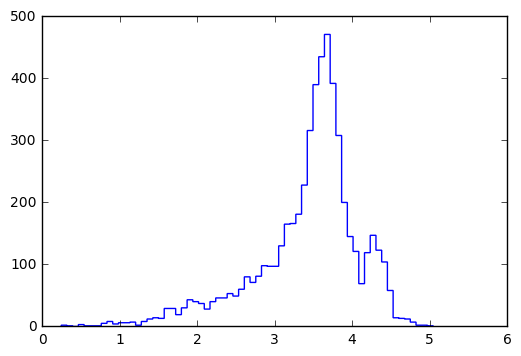

In [24]:
from astroML.plotting import hist as fancyhist
fancyhist(testdatacand['zphotRF'], bins="freedman", histtype="step")